In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"   #(xxxx is your specific GPU ID)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Flatten, GlobalAveragePooling2D
from MyEarlyStopping import MyEarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder  
import pandas as pd

In [3]:
All_data = ImageDataGenerator(preprocessing_function=preprocess_input)
All_data_generator = All_data.flow_from_directory('Mel_Audio_folder_digits',
                                                batch_size=1,
                                                target_size=(224,224),
                                                class_mode='categorical',
                                               shuffle=False)

Found 30000 images belonging to 10 classes.


In [4]:
image_names = All_data_generator.filenames
image_no = [i.split("/")[1].split("_")[2].split(".")[0] for i in image_names]
image_no = np.array(list(map(int, image_no)))
ALL_participant_class = [i.split("/")[1].split("_")[1] for i in image_names]
ALL_participant_class = np.array(list(map(int, ALL_participant_class)))
command_class = All_data_generator.classes
All_participant_class = tf.keras.utils.to_categorical(ALL_participant_class-1, num_classes=60)
All_command_class = tf.keras.utils.to_categorical(command_class, num_classes=10)
All_command_uniform = All_command_class*0+1/10

In [5]:
All_Inputs = [next(All_data_generator)[0][0] for _ in range(len(All_data_generator))]
All_Inputs = np.array(All_Inputs)

# performance of initial model 

In [6]:
# Existing_Train_participant_class = np.load("Existing_Train_participant_class_28.npy")
# Existing_Train_participant_uniform = np.load("Existing_Train_participant_uniform_28.npy")
# Existing_Train_command_class = np.load("Existing_Train_command_class_28.npy")
# Existing_Train_command_uniform = np.load("Existing_Train_command_uniform_28.npy")
# Existing_Train_Inputs = np.load("Existing_Train_Inputs_28.npy")
# Existing_Test_participant_class = np.load("Existing_Test_participant_class_28.npy")
# Existing_Test_participant_uniform = np.load("Existing_Test_participant_uniform_28.npy")
# Existing_Test_command_class = np.load("Existing_Test_command_class_28.npy")
# Existing_Test_command_uniform = np.load("Existing_Test_command_uniform_28.npy")
# Existing_Test_Inputs = np.load("Existing_Test_Inputs_28.npy")

Existing_select_indexs = (image_no<=19)&(ALL_participant_class<=5)
Existing_Train_Inputs = All_Inputs[Existing_select_indexs]
Existing_Train_participant_class = All_participant_class[Existing_select_indexs][:,0:5]
Existing_Train_participant_uniform = Existing_Train_participant_class*0+1/5
Existing_Train_command_class = All_command_class[Existing_select_indexs]
Existing_Train_command_uniform = Existing_Train_command_class*0+1/10



Existing_Test_Inputs = All_Inputs[Existing_select_indexs]
Existing_Test_participant_class = All_participant_class[Existing_select_indexs][:,0:5]
Existing_Test_participant_uniform = Existing_Test_participant_class*0+1/5
Existing_Test_command_class = All_command_class[Existing_select_indexs]
Existing_Test_command_uniform = Existing_Test_command_class*0+1/10

speaker_number = Existing_Train_participant_class.shape[1]
speaker_number

5

In [7]:
# load the initial model 
resnet_model_0 = tf.keras.models.load_model('Digital_data_Initial_group_model_0531_free&unfree.h5')

In [8]:
command_accuracy = []
subject_accuracy = []
for i in range(1,61):
    
    select_indexs_test_i = (image_no>39)&(image_no<=49)&(ALL_participant_class==i)
    Test_Inputs_i = All_Inputs[select_indexs_test_i]
    Test_command_class_i = All_command_class[select_indexs_test_i]
    Test_command_uniform_i = Test_command_class_i*0+1/10
    
    # subject prediction 
    predictions = resnet_model_0.predict(Test_Inputs_i)[0]
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.array([j.split("/")[1].split("_")[1] for j in All_data_generator.filenames])
    true_classes = np.array(list(map(int, true_classes)))[select_indexs_test_i]-1
    
    subject_accuracy.append(round(sum(x == y for x, y in zip(true_classes, predicted_classes)) / len(true_classes),4))
    
    # command prediction 
    predictions = resnet_model_0.predict(Test_Inputs_i)[1]
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.array([j.split("/")[0] for j in All_data_generator.filenames])
    true_classes = np.array(list(map(int, true_classes)))[select_indexs_test_i]
    
    command_accuracy.append(round(sum(x == y for x, y in zip(true_classes, predicted_classes)) / len(true_classes),4))


In [9]:
performance_command = pd.DataFrame(columns=["Subject_No","add_data"] + list(range(1,61)))
performance_speaker = pd.DataFrame(columns=["Subject_No","add_data"] + list(range(1,61)))
performance_command = performance_command.append({"Subject_No":5,"add_data":"40%"}, ignore_index=True)
performance_speaker = performance_speaker.append({"Subject_No":5,"add_data":"40%"}, ignore_index=True)
performance_command.iloc[performance_command['Subject_No']==5,2:] = command_accuracy
performance_speaker.iloc[performance_speaker['Subject_No']==5,2:] = subject_accuracy

# performance_speaker = pd.read_csv("performance_speaker_0531_5->30_final.csv")
# performance_command = pd.read_csv("performance_command_0531_5->30_final.csv")



# refine models

In [10]:
actv_fun_1_1 = "relu" 
actv_fun_1_2 = "sigmoid"
shape_1_1 = 128
shape_1_2 = 256
actv_fun_2_1 = "sigmoid" 
actv_fun_2_2 = "sigmoid"
shape_2_1 = 512
shape_2_2 = 512


In [11]:
# new_speaker = 6
add_data = 5 # 10%-->5; 20%-->10; 30%--> 15; 40% -->20;

for new_speaker in range(6,19):
    
    ####################################################################################################################
    # training 
    new_select_indexs = (image_no<=add_data-1)&(ALL_participant_class==new_speaker)
    new_Train_Inputs = All_Inputs[new_select_indexs]
    new_Train_participant_class = All_participant_class[new_select_indexs][:,0:new_speaker]
    new_Train_participant_uniform = new_Train_participant_class*0+1/new_speaker
    new_Train_command_class = All_command_class[new_select_indexs]
    new_Train_command_uniform = new_Train_command_class*0+1/10

    # testing
    new_select_indexs_test = (image_no>39)&(image_no<=49)&(ALL_participant_class==new_speaker)
    new_Test_Inputs = All_Inputs[new_select_indexs_test]
    new_Test_participant_class = All_participant_class[new_select_indexs_test][:,0:new_speaker]
    new_Test_participant_uniform = new_Test_participant_class*0+1/new_speaker
    new_Test_command_class = All_command_class[new_select_indexs_test]
    new_Test_command_uniform = new_Test_command_class*0+1/10

    # combine training
    update_Train_participant_class = np.vstack((np.hstack((Existing_Train_participant_class,np.zeros([len(Existing_Train_participant_class),1]))),new_Train_participant_class))
    update_Train_participant_uniform = update_Train_participant_class*0+1/new_speaker
    update_Train_command_class = np.vstack((Existing_Train_command_class,new_Train_command_class))
    update_Train_command_uniform = update_Train_command_class*0+1/10
    update_Train_Inputs = np.vstack((Existing_Train_Inputs,new_Train_Inputs))

    # combine testing
    update_Test_participant_class = np.vstack((np.hstack((Existing_Test_participant_class,np.zeros([len(Existing_Test_participant_class),1]))),new_Test_participant_class))
    update_Test_participant_uniform = update_Test_participant_class*0+1/new_speaker
    update_Test_command_class = np.vstack((Existing_Test_command_class,new_Test_command_class))
    update_Test_command_uniform = update_Test_command_class*0+1/10
    update_Test_Inputs = np.vstack((Existing_Test_Inputs,new_Test_Inputs))
    

    ####################################################################################################################
    ### feature extraction layers
    resnet_model = Model(resnet_model_0.input, resnet_model_0.layers[174].output)

    d = resnet_model.output.shape[-1] # dimension of last layer

    ###################### model 1 ###################### 
#      # chenge the weights in speaker task to initial weights
#     initializer = tf.keras.initializers.GlorotUniform()
#     w1 = initializer(shape=resnet_model.get_layer(name = "weight_1").get_weights()[0].shape)
#     initializer = tf.keras.initializers.Zeros()
#     w2 = initializer(shape=resnet_model.get_layer(name = "weight_1").get_weights()[1].shape)
#     resnet_model.get_layer(name = "weight_1").set_weights([w1,w2])
    
    layer_1_0 = tf.keras.layers.Dense(d,name="weight_1")(resnet_model.output) #times weight before flatten
    layer_1_1 = tf.keras.layers.Flatten(name='flatten_1')(layer_1_0)

    Dense_1_1 = tf.keras.layers.Dense(shape_1_1, activation = actv_fun_1_1,name='fc1_1')
    layer_1_2 = Dense_1_1(layer_1_1)
    Dense_1_2 = tf.keras.layers.Dense(shape_1_2, activation = actv_fun_1_2,name='fc1_2')
    layer_1_3 = Dense_1_2(layer_1_2)

    Dense_1_3 = tf.keras.layers.Dense(new_speaker, activation='softmax' ,name='participant_output')
    out_layer_1 = Dense_1_3(layer_1_3)

    ###################### model 2 ###################### 
    w1 = tf.constant_initializer(resnet_model_0.get_layer(name = "weight_2").get_weights()[0])
    w2 = tf.constant_initializer(resnet_model_0.get_layer(name = "weight_2").get_weights()[1])
    layer_2_0 = tf.keras.layers.Dense(d,name="weight_2",kernel_initializer = w1 ,bias_initializer = w2)(resnet_model.output) #times weight before flatten

    layer_2_1 = tf.keras.layers.Flatten(name='flatten_2')(layer_2_0)

    w1 = tf.constant_initializer(resnet_model_0.get_layer(name = "fc2_1").get_weights()[0])
    w2 = tf.constant_initializer(resnet_model_0.get_layer(name = "fc2_1").get_weights()[1])
    Dense_2_1 = tf.keras.layers.Dense(shape_2_1, activation=actv_fun_2_1,kernel_initializer = w1 ,bias_initializer = w2,name='fc2_1')
    layer_2_2  = Dense_2_1(layer_2_1)

    w1 = tf.constant_initializer(resnet_model_0.get_layer(name = "fc2_2").get_weights()[0])
    w2 = tf.constant_initializer(resnet_model_0.get_layer(name = "fc2_2").get_weights()[1])
    Dense_2_2 = tf.keras.layers.Dense(shape_2_2, activation=actv_fun_2_2,kernel_initializer = w1 ,bias_initializer = w2, name='fc2_2')
    layer_2_3  = Dense_2_2(layer_2_2)

    w1 = tf.constant_initializer(resnet_model_0.get_layer(name = "command_output").get_weights()[0])
    w2 = tf.constant_initializer(resnet_model_0.get_layer(name = "command_output").get_weights()[1])
    Dense_2_3 = tf.keras.layers.Dense(10, activation='softmax',kernel_initializer = w1 ,bias_initializer = w2,name='command_output')
    out_layer_2 = Dense_2_3(layer_2_3)

    ###################### model 1' ###################### 
    layer_1_2_  = Dense_2_1(layer_1_1)
    layer_1_3_  = Dense_2_2(layer_1_2_)
    out_layer_1_ = Dense_2_3(layer_1_3_)

    ###################### model 1' ###################### 
    layer_2_2_  = Dense_1_1(layer_2_1)
    layer_2_3_  = Dense_1_2(layer_2_2_)
    out_layer_2_ = Dense_1_3(layer_2_3_)

    resnet_model = tf.keras.Model(resnet_model.input, [out_layer_1,out_layer_2,out_layer_1_,out_layer_2_])

    # resnet_model.summary() 

    w_1, w_2, w_1_, w_2_ = 1,1,1,1
    ##################### training ############################
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    callbacks = [MyEarlyStopping(monitor1 = resnet_model.layers[-1].name+'_accuracy',
                                  monitor2 = resnet_model.layers[-2].name+'_accuracy',
                                  patience=10,restore_best_weights=True)]
    resnet_model.compile(optimizer=opt, loss=["categorical_crossentropy","categorical_crossentropy","mse","mse"],
                         loss_weights=[w_1, w_2, w_1_, w_2_], metrics=['accuracy'])
    
    for layer in resnet_model.layers[0:175]:
        layer.trainable = False
    history = resnet_model.fit(update_Train_Inputs, 
                               {resnet_model.layers[-2].name:update_Train_participant_class, 
                                resnet_model.layers[-1].name:update_Train_command_class,
                                resnet_model.layers[-1].name+"_1":update_Train_command_uniform, 
                                resnet_model.layers[-2].name+"_1":update_Train_participant_uniform}, 
                               callbacks=callbacks,
                               batch_size=64,
                               epochs=10)
    
    for layer in resnet_model.layers[0:175]:
        layer.trainable = True
    history = resnet_model.fit(update_Train_Inputs, 
                               {resnet_model.layers[-2].name:update_Train_participant_class, 
                                resnet_model.layers[-1].name:update_Train_command_class,
                                resnet_model.layers[-1].name+"_1":update_Train_command_uniform, 
                                resnet_model.layers[-2].name+"_1":update_Train_participant_uniform}, 
                               callbacks=callbacks,
                               batch_size=64,
                               epochs=10)

 
    
    resnet_model.save('resnet_model_0531_digit_refine_group_5->30_final_free&unfree.h5')
    ####################################################################################################################
    ####################################################################################################################

    subject_accuracy = []
    command_accuracy = []
    
    for i in range(1,61):

        select_indexs_test_i = (image_no>39)&(image_no<=49)&(ALL_participant_class==i)
        Test_Inputs_i = All_Inputs[select_indexs_test_i]
        Test_command_class_i = All_command_class[select_indexs_test_i]
        Test_command_uniform_i = Test_command_class_i*0+1/10

        # subject prediction 
        predictions = resnet_model.predict(Test_Inputs_i)[0]
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.array([j.split("/")[1].split("_")[1] for j in All_data_generator.filenames])
        true_classes = np.array(list(map(int, true_classes)))[select_indexs_test_i]-1

        subject_accuracy.append(round(sum(x == y for x, y in zip(true_classes, predicted_classes)) / len(true_classes),4))

        # command prediction 
        predictions = resnet_model.predict(Test_Inputs_i)[1]
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.array([j.split("/")[0] for j in All_data_generator.filenames])
        true_classes = np.array(list(map(int, true_classes)))[select_indexs_test_i]

        command_accuracy.append(round(sum(x == y for x, y in zip(true_classes, predicted_classes)) / len(true_classes),4))
    
    # store the performance 
    performance_command = performance_command.append({"Subject_No":new_speaker,"add_data":str(int(100*add_data/50))+"%"}, ignore_index=True)
    performance_speaker = performance_speaker.append({"Subject_No":new_speaker,"add_data":str(int(100*add_data/50))+"%"}, ignore_index=True)
    performance_command.iloc[performance_command['Subject_No']==new_speaker,2:] = command_accuracy
    performance_speaker.iloc[performance_speaker['Subject_No']==new_speaker,2:] = subject_accuracy
    
    
    resnet_model_0 = tf.keras.models.load_model('resnet_model_0531_digit_refine_group_5->30_final_free&unfree.h5')
    Existing_Train_participant_class = update_Train_participant_class 
    Existing_Train_participant_uniform =  update_Train_participant_uniform
    Existing_Train_command_class = update_Train_command_class 
    Existing_Train_command_uniform = update_Train_command_uniform 
    Existing_Train_Inputs = update_Train_Inputs
    Existing_Test_participant_class = update_Test_participant_class 
    Existing_Test_participant_uniform =  update_Test_participant_uniform
    Existing_Test_command_class = update_Test_command_class 
    Existing_Test_command_uniform = update_Test_command_uniform 
    Existing_Test_Inputs = update_Test_Inputs

Epoch 1/10
17/17 [==============================] - 4s 262ms/step - loss: 1.6796 - participant_output_loss: 1.0332 - command_output_loss: 0.6380 - command_output_1_loss: 0.0016 - participant_output_1_loss: 0.0069 - participant_output_accuracy: 0.6886 - command_output_accuracy: 0.8895 - command_output_1_accuracy: 0.1724 - participant_output_1_accuracy: 0.0733
Epoch 2/10
17/17 [==============================] - 4s 227ms/step - loss: 0.3217 - participant_output_loss: 0.1867 - command_output_loss: 0.1327 - command_output_1_loss: 9.2442e-04 - participant_output_1_loss: 0.0014 - participant_output_accuracy: 0.9800 - command_output_accuracy: 0.9990 - command_output_1_accuracy: 0.0352 - participant_output_1_accuracy: 0.1905
Epoch 3/10
17/17 [==============================] - 4s 235ms/step - loss: 0.1416 - participant_output_loss: 0.0587 - command_output_loss: 0.0813 - command_output_1_loss: 6.6935e-04 - participant_output_1_loss: 8.9869e-04 - participant_output_accuracy: 0.9990 - command_outpu

18/18 [==============================] - 4s 245ms/step - loss: 0.0583 - participant_output_loss: 0.0490 - command_output_loss: 0.0071 - command_output_1_loss: 0.0018 - participant_output_1_loss: 3.7415e-04 - participant_output_accuracy: 0.9955 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.1027 - participant_output_1_accuracy: 0.1582
Epoch 4/10
18/18 [==============================] - 5s 250ms/step - loss: 0.0315 - participant_output_loss: 0.0252 - command_output_loss: 0.0044 - command_output_1_loss: 0.0017 - participant_output_1_loss: 2.5940e-04 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.1355 - participant_output_1_accuracy: 0.1409
Epoch 5/10
18/18 [==============================] - 4s 235ms/step - loss: 0.0233 - participant_output_loss: 0.0182 - command_output_loss: 0.0033 - command_output_1_loss: 0.0016 - participant_output_1_loss: 1.9056e-04 - participant_output_accuracy: 1.0000 - command_output_accuracy:

18/18 [==============================] - 4s 236ms/step - loss: 0.0224 - participant_output_loss: 0.0197 - command_output_loss: 7.6495e-04 - command_output_1_loss: 0.0017 - participant_output_1_loss: 1.0995e-04 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.2174 - participant_output_1_accuracy: 0.0870
Epoch 6/10
18/18 [==============================] - 4s 235ms/step - loss: 0.0188 - participant_output_loss: 0.0165 - command_output_loss: 6.2464e-04 - command_output_1_loss: 0.0016 - participant_output_1_loss: 8.9357e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.1626 - participant_output_1_accuracy: 0.0870
Epoch 7/10
18/18 [==============================] - 4s 213ms/step - loss: 0.0168 - participant_output_loss: 0.0146 - command_output_loss: 5.3052e-04 - command_output_1_loss: 0.0016 - participant_output_1_loss: 7.5503e-05 - participant_output_accuracy: 1.0000 - command_outp

19/19 [==============================] - 4s 208ms/step - loss: 0.0171 - participant_output_loss: 0.0153 - command_output_loss: 2.7310e-04 - command_output_1_loss: 0.0015 - participant_output_1_loss: 7.3419e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.1842 - participant_output_1_accuracy: 0.1283
Epoch 8/10
19/19 [==============================] - 4s 205ms/step - loss: 0.0160 - participant_output_loss: 0.0142 - command_output_loss: 2.5163e-04 - command_output_1_loss: 0.0015 - participant_output_1_loss: 6.3996e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.2075 - participant_output_1_accuracy: 0.1175
Epoch 9/10
19/19 [==============================] - 4s 208ms/step - loss: 0.0150 - participant_output_loss: 0.0133 - command_output_loss: 2.3711e-04 - command_output_1_loss: 0.0015 - participant_output_1_loss: 5.6440e-05 - participant_output_accuracy: 1.0000 - command_outp

20/20 [==============================] - 4s 206ms/step - loss: 0.0400 - participant_output_loss: 0.0376 - command_output_loss: 8.2552e-04 - command_output_1_loss: 0.0015 - participant_output_1_loss: 1.0871e-04 - participant_output_accuracy: 0.9944 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.1296 - participant_output_1_accuracy: 0.0712
Epoch 10/10
20/20 [==============================] - 4s 210ms/step - loss: 0.0299 - participant_output_loss: 0.0274 - command_output_loss: 9.3801e-04 - command_output_1_loss: 0.0014 - participant_output_1_loss: 9.8780e-05 - participant_output_accuracy: 0.9976 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.0736 - participant_output_1_accuracy: 0.0704
Epoch 1/10
20/20 [==============================] - 5s 237ms/step - loss: 0.0193 - participant_output_loss: 0.0172 - command_output_loss: 6.3920e-04 - command_output_1_loss: 0.0014 - participant_output_1_loss: 9.0275e-05 - participant_output_accuracy: 1.0000 - command_out

21/21 [==============================] - 5s 240ms/step - loss: 0.0130 - participant_output_loss: 0.0116 - command_output_loss: 1.7214e-04 - command_output_1_loss: 0.0012 - participant_output_1_loss: 4.5677e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.3292 - participant_output_1_accuracy: 0.0662
Epoch 2/10
21/21 [==============================] - 4s 208ms/step - loss: 0.0122 - participant_output_loss: 0.0108 - command_output_loss: 1.6268e-04 - command_output_1_loss: 0.0012 - participant_output_1_loss: 4.4111e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.3192 - participant_output_1_accuracy: 0.0754
Epoch 3/10
21/21 [==============================] - 5s 217ms/step - loss: 0.0116 - participant_output_loss: 0.0102 - command_output_loss: 1.5206e-04 - command_output_1_loss: 0.0012 - participant_output_1_loss: 4.1179e-05 - participant_output_accuracy: 1.0000 - command_outp

22/22 [==============================] - 5s 235ms/step - loss: 0.0300 - participant_output_loss: 0.0241 - command_output_loss: 0.0037 - command_output_1_loss: 0.0020 - participant_output_1_loss: 1.7554e-04 - participant_output_accuracy: 0.9985 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.0296 - participant_output_1_accuracy: 0.1096
Epoch 4/10
22/22 [==============================] - 5s 240ms/step - loss: 0.0215 - participant_output_loss: 0.0187 - command_output_loss: 9.9050e-04 - command_output_1_loss: 0.0017 - participant_output_1_loss: 1.2808e-04 - participant_output_accuracy: 0.9993 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.0578 - participant_output_1_accuracy: 0.0785
Epoch 5/10
22/22 [==============================] - 5s 240ms/step - loss: 0.0138 - participant_output_loss: 0.0116 - command_output_loss: 4.7846e-04 - command_output_1_loss: 0.0016 - participant_output_1_loss: 1.0090e-04 - participant_output_accuracy: 1.0000 - command_output_a

22/22 [==============================] - 5s 217ms/step - loss: 0.0122 - participant_output_loss: 0.0100 - command_output_loss: 6.6124e-05 - command_output_1_loss: 0.0021 - participant_output_1_loss: 2.3033e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.0129 - participant_output_1_accuracy: 0.0607
Epoch 6/10
22/22 [==============================] - 5s 215ms/step - loss: 0.0117 - participant_output_loss: 0.0096 - command_output_loss: 6.3858e-05 - command_output_1_loss: 0.0021 - participant_output_1_loss: 2.2157e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.0250 - participant_output_1_accuracy: 0.0629
Epoch 7/10
22/22 [==============================] - 5s 210ms/step - loss: 0.0112 - participant_output_loss: 0.0091 - command_output_loss: 6.1027e-05 - command_output_1_loss: 0.0020 - participant_output_1_loss: 2.0568e-05 - participant_output_accuracy: 1.0000 - command_outp

23/23 [==============================] - 5s 218ms/step - loss: 0.0148 - participant_output_loss: 0.0134 - command_output_loss: 1.0779e-04 - command_output_1_loss: 0.0012 - participant_output_1_loss: 4.7329e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.0552 - participant_output_1_accuracy: 0.0731
Epoch 8/10
23/23 [==============================] - 5s 229ms/step - loss: 0.0141 - participant_output_loss: 0.0127 - command_output_loss: 1.0317e-04 - command_output_1_loss: 0.0012 - participant_output_1_loss: 4.4050e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.0262 - participant_output_1_accuracy: 0.0800
Epoch 9/10
23/23 [==============================] - 5s 226ms/step - loss: 0.0135 - participant_output_loss: 0.0121 - command_output_loss: 9.8608e-05 - command_output_1_loss: 0.0012 - participant_output_1_loss: 4.2580e-05 - participant_output_accuracy: 1.0000 - command_outp

24/24 [==============================] - 5s 207ms/step - loss: 0.0115 - participant_output_loss: 0.0100 - command_output_loss: 6.6077e-05 - command_output_1_loss: 0.0014 - participant_output_1_loss: 3.0140e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.0380 - participant_output_1_accuracy: 0.0727
Epoch 10/10
24/24 [==============================] - 5s 212ms/step - loss: 0.0110 - participant_output_loss: 0.0095 - command_output_loss: 6.2566e-05 - command_output_1_loss: 0.0014 - participant_output_1_loss: 2.8875e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.0347 - participant_output_1_accuracy: 0.0800
Epoch 1/10
25/25 [==============================] - 6s 248ms/step - loss: 0.3810 - participant_output_loss: 0.3699 - command_output_loss: 0.0011 - command_output_1_loss: 0.0095 - participant_output_1_loss: 4.4611e-04 - participant_output_accuracy: 0.9310 - command_output_

25/25 [==============================] - 6s 240ms/step - loss: 0.4683 - participant_output_loss: 0.4399 - command_output_loss: 0.0196 - command_output_1_loss: 0.0083 - participant_output_1_loss: 5.7116e-04 - participant_output_accuracy: 0.9413 - command_output_accuracy: 0.9969 - command_output_1_accuracy: 0.1094 - participant_output_1_accuracy: 0.0000e+00
Epoch 2/10
25/25 [==============================] - 6s 224ms/step - loss: 0.0955 - participant_output_loss: 0.0919 - command_output_loss: 6.9412e-04 - command_output_1_loss: 0.0027 - participant_output_1_loss: 2.4485e-04 - participant_output_accuracy: 0.9987 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.1531 - participant_output_1_accuracy: 0.0119
Epoch 3/10
25/25 [==============================] - 6s 223ms/step - loss: 0.0652 - participant_output_loss: 0.0628 - command_output_loss: 2.6441e-04 - command_output_1_loss: 0.0020 - participant_output_1_loss: 1.4310e-04 - participant_output_accuracy: 1.0000 - command_outp

26/26 [==============================] - 7s 256ms/step - loss: 0.4804 - participant_output_loss: 0.4721 - command_output_loss: 3.1508e-04 - command_output_1_loss: 0.0075 - participant_output_1_loss: 5.2178e-04 - participant_output_accuracy: 0.9315 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.0945 - participant_output_1_accuracy: 0.1079
Epoch 2/10
26/26 [==============================] - 6s 229ms/step - loss: 0.1072 - participant_output_loss: 0.1037 - command_output_loss: 2.5726e-04 - command_output_1_loss: 0.0032 - participant_output_1_loss: 1.1665e-04 - participant_output_accuracy: 0.9964 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.1636 - participant_output_1_accuracy: 0.1121
Epoch 3/10
26/26 [==============================] - 6s 224ms/step - loss: 0.0818 - participant_output_loss: 0.0789 - command_output_loss: 2.1075e-04 - command_output_1_loss: 0.0026 - participant_output_1_loss: 6.2673e-05 - participant_output_accuracy: 0.9976 - command_outp

In [12]:
new_speaker

18

In [13]:
performance_speaker.iloc[:,0:]

,Subject_No,add_data,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,60
0,5,40%,0.99,0.99,1,0.98,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,10%,0.99,1,1,1,1,0.96,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,10%,1,1,1,1,1,0.98,1,0,...,0,0,0,0,0,0,0,0,0,0
3,8,10%,1,1,1,1,1,0.95,0.99,1,...,0,0,0,0,0,0,0,0,0,0
4,9,10%,0.99,1,1,0.99,1,0.99,1,1,...,0,0,0,0,0,0,0,0,0,0
5,10,10%,0.99,1,1,0.99,1,0.99,0.99,0.99,...,0,0,0,0,0,0,0,0,0,0
6,11,10%,0.99,1,1,1,1,0.98,0.99,0.99,...,0,0,0,0,0,0,0,0,0,0
7,12,10%,0.98,1,0.99,1,1,0.98,0.99,0.96,...,0,0,0,0,0,0,0,0,0,0
8,13,10%,0.99,1,1,1,1,0.99,1,0.99,...,0,0,0,0,0,0,0,0,0,0
9,14,10%,1,1,1,1,1,1,0.99,1,...,0,0,0,0,0,0,0,0,0,0


In [14]:
performance_command.iloc[:,0:]

,Subject_No,add_data,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,60
0,5,40%,0.99,1,1,1,1,0.96,0.97,1,...,0.96,0.88,0.89,0.99,0.99,0.97,0.86,0.95,0.9,0.88
1,6,10%,1,1,1,1,1,1,0.98,1,...,0.98,0.96,0.99,0.99,1,0.99,0.91,1,0.97,0.92
2,7,10%,1,1,0.99,1,1,1,1,1,...,0.98,0.92,0.99,0.97,0.99,0.96,0.85,0.98,0.96,0.85
3,8,10%,1,1,1,1,1,1,1,1,...,0.97,0.92,0.98,0.96,0.99,1,0.88,0.98,0.98,0.89
4,9,10%,1,1,0.99,1,1,0.99,1,1,...,0.97,0.97,1,0.93,1,0.99,0.86,0.99,0.98,0.89
5,10,10%,1,1,0.99,1,1,1,0.99,1,...,0.98,0.96,1,0.95,1,0.94,0.86,0.98,0.94,0.84
6,11,10%,1,1,1,1,1,1,1,1,...,0.97,0.94,1,0.92,1,0.95,0.84,0.99,0.97,0.84
7,12,10%,1,1,1,1,1,0.99,1,1,...,0.98,0.91,1,0.98,1,0.97,0.83,0.99,0.95,0.88
8,13,10%,1,1,1,1,1,1,0.99,1,...,1,0.93,0.99,0.98,1,0.95,0.83,1,0.96,0.84
9,14,10%,1,1,1,0.99,1,1,0.99,1,...,1,0.96,1,0.98,1,0.99,0.87,1,0.97,0.85


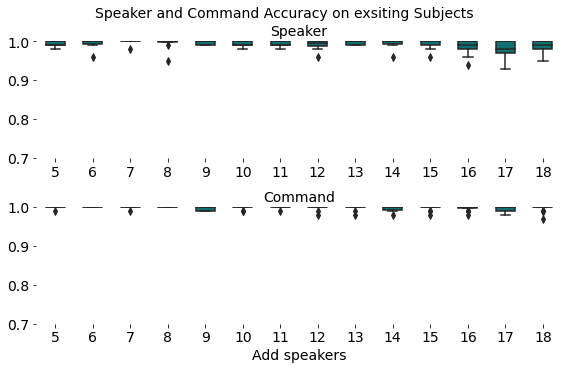

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(8,5))
plt.subplot(2,1,1)
sns.boxplot(data=performance_speaker.transpose()[performance_speaker.transpose().iloc[2:,:]>0],width=0.5,color="teal")
plt.box(False)
plt.ylim([0.7,1.00])
plt.yticks(fontsize=14)
plt.xticks(range(len(performance_speaker)),performance_speaker["Subject_No"],fontsize=14)
plt.title("Speaker",fontsize=14)
plt.ylabel(None)
plt.subplot(2,1,2)
sns.boxplot(data=performance_command.transpose()[performance_speaker.transpose().iloc[2:,:]>0],width=0.5,color="teal")
plt.box(False)
plt.ylim([0.7,1.00])
plt.yticks(fontsize=14)
plt.xticks(range(len(performance_speaker)),performance_speaker["Subject_No"],fontsize=14)
plt.ylabel(None)
plt.title("Command",fontsize=14)
plt.xlabel("Add speakers",fontsize=14)
# fig.text(0.5, -0.05, 'Accuracy', ha='center', va='center', rotation='horizontal',fontsize=14)
fig.text(0.5, 1.0, 'Speaker and Command Accuracy on exsiting Subjects', ha='center', va='center', rotation='horizontal',fontsize=14)
plt.tight_layout()
plt.show()

In [16]:
np.save("Existing_Train_participant_class.npy", Existing_Train_participant_class)
np.save("Existing_Train_participant_uniform.npy", Existing_Train_participant_uniform)
np.save("Existing_Train_command_class.npy", Existing_Train_command_class)
np.save("Existing_Train_command_uniform.npy", Existing_Train_command_uniform)
np.save("Existing_Train_Inputs.npy", Existing_Train_Inputs)
np.save("Existing_Test_participant_class.npy", Existing_Test_participant_class)
np.save("Existing_Test_participant_uniform.npy", Existing_Test_participant_uniform)
np.save("Existing_Test_command_class.npy", Existing_Test_command_class)
np.save("Existing_Test_command_uniform.npy", Existing_Test_command_uniform)
np.save("Existing_Test_Inputs.npy", Existing_Test_Inputs)

In [17]:
performance_speaker.to_csv("performance_speaker_0531_5->30_final_free&unfree.csv",index=False)
performance_command.to_csv("performance_command_0531_5->30_final_free&unfree.csv",index=False)

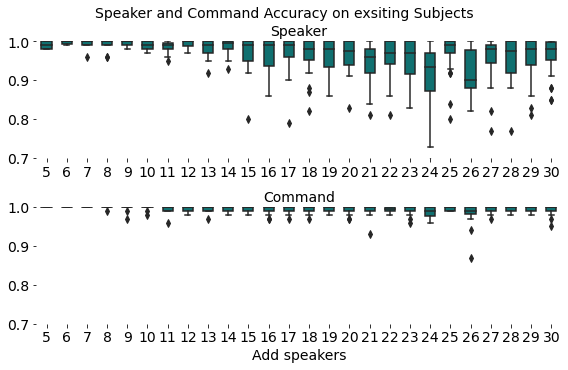

In [14]:
# old fig